In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)

import os
import pickle

from copy import deepcopy

import tqdm

from sklearn.datasets import make_spd_matrix

In [2]:
outdir = './output/synthetic/univariate/gradual_mixture/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [4]:
def compute_tau(X, theta):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [5]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0)
    s2 = X.T.dot(Z).ravel()
    s3 = (X**2).T.dot(Z).ravel()
    
    return s1, s2, s3

In [6]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = np.sqrt(s.s3 / (s.s1 + eps) - mu**2)
    return pi, mu, sigma

In [7]:
class SuffStat:
    def __init__(self):
        pass

In [8]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.random(K)
        self.s2 = np.random.random(K)
        self.s3 = np.random.random(K)

In [26]:
def sra(X, X_init, theta0, rho, gamma):
    K = len(theta0.mu)
    N = X.shape[0]
    
    theta_est = np.zeros((N, 3*K+1))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(len(theta0.pi), 1)
    
    # initialization
    #tau = compute_tau(X[:10, :], theta)
    #tau = compute_tau(X[:5, :], theta)
    #s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:5, :], tau)
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        s2_indiv_new = X[ind_n, :] * tau_indiv_new
        s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new

        if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
                
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))

    return theta_est

In [10]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [11]:
pi = np.array([0.2, 0.8])
pi0 = pi.copy()

sigma = np.array([0.1, 0.1])
sigma0 = np.array([0.2, 0.2])

mu0 = [0.1, -0.1]

theta0 = Theta(pi0, mu0, sigma0)

seed0 = 1
seed = seed0

In [12]:
pi

array([0.2, 0.8])

In [13]:
sigma

array([0.1, 0.1])

In [18]:
mu1 = np.array([0.5, -0.5])
mu2 = np.array([1.0, -1.0])

In [28]:
gamma = 3
ratio = 0.1
M = 5
rho_orig = ratio/(2.0*gamma) * np.exp(-gamma**2/M**2)
alpha = 0.05
alpha_orig = 0.01
rho = rho_orig * (1 - alpha_orig)/(1 - alpha)

u = 20
N = 10000
D = 1

rho_const = np.repeat(rho, 2*N)

np.random.seed(0)
X = np.zeros((2*N, D))
Xj_former = generate_data(N, pi, mu1, sigma)
X[:N, :] = Xj_former
#Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
Xj_trans = np.vstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma).reshape(1, -1) for t in range(N, N+300) ])
X[N:(N+300), :] = Xj_trans
Xj_latter = generate_data(N-300, pi, mu2, sigma)
X[N+300:, :] = Xj_latter

alpha = 0.05
idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)

X_init = np.random.uniform(-2, 2, (10, 1))

theta_est_sra = sra(X, X_init, theta0, rho_const, gamma)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [29]:
rho

0.012117536189654748

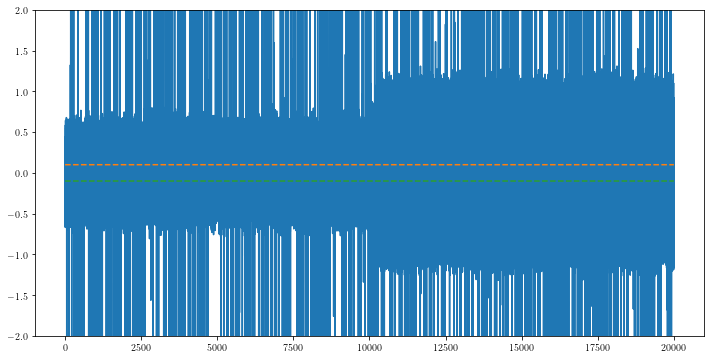

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(X.ravel())
plt.plot(theta_est_sra[:, 3], linestyle='dashed')
plt.plot(theta_est_sra[:, 4], linestyle='dashed')
plt.ylim(-2, 2)
plt.show()

In [32]:
gamma = 3.0
rho = 0.0116
ratio = 0.1
alpha_orig = 0.01
M = 5
alpha_list = [0.01, 0.05, 0.1]
u = 20
n_trial = 10
N = 10000

pi = np.array([0.5, 0.5])
mu1 = np.array([0.5, -0.5])
mu2 = np.array([1.0, -1.0])
sigma = np.array([0.1, 0.1])

mse_eval_alpha =  np.zeros((n_trial, len(alpha_list)))
mse_former_alpha = np.zeros((n_trial, len(alpha_list)))
mse_latter_alpha = np.zeros((n_trial, len(alpha_list)))
mse_overall_alpha =  np.zeros((n_trial, len(alpha_list)))

D = 1

for trial in tqdm.tqdm(range(n_trial)):
    np.random.seed(trial)
    X = np.zeros((2*N, D))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, :] = Xj_former
    #Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
    Xj_trans = np.vstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma).reshape(1, -1) for t in range(N, N+300) ])
    X[N:(N+300), :] = Xj_trans
    Xj_latter = generate_data(N-300, pi, mu2, sigma)
    X[N+300:, :] = Xj_latter
    
    for j, alpha in enumerate(alpha_list):
        idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
        X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)
        
        X_init = np.random.uniform(-0.5, 0.5, (10, 1))

        rho = ratio * (1-alpha_orig)/(1-alpha) *np.exp(-gamma**2/M**2)
        rho_const = np.repeat([rho], X.shape[0])
        theta_est_sra = sra(X, X_init, theta0, rho_const, gamma)

        mse_eval = np.sum((theta_est_sra[500:1000, 3:5] - mu1)**2, axis=1)
        mse_eval_alpha[trial, j] = np.mean(mse_eval)
        
        mse_former = np.sum((theta_est_sra[1000:10000, 3:5] - mu1)**2, axis=1)
        mse_former_alpha[trial, j] = np.mean(mse_former)
        
        mse_latter = np.sum((theta_est_sra[10000:, 3:5] - mu2)**2, axis=1)
        mse_latter_alpha[trial, j] = np.mean(mse_latter)

        mse_overall = np.hstack((mse_former, mse_latter))
        mse_overall_alpha[trial, j] = np.mean(mse_overall)

        print(np.mean(mse_eval), np.mean(mse_former), np.mean(mse_latter), np.mean(mse_overall))

  0%|          | 0/10 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0013241667398113295 0.0016080466840137809 0.007267268884994965 0.004586584684530194
0.0028651443933561814 0.007416312008718397 0.009928151772581294 0.008738332937067292


 10%|█         | 1/10 [01:34<14:11, 94.56s/it]

0.01446890704014918 0.01378753286181607 0.012027231502142913 0.012861058461988095
0.0027828433603862097 0.0018379621222346211 0.007343142081242462 0.004735425258554538
0.006326138154849483 0.0060009474489323795 0.010326409393582073 0.008277506367169061


 20%|██        | 2/10 [03:11<12:49, 96.15s/it]

0.012195422031200493 0.012033868348255504 0.014022024703114068 0.01308026642976001
0.0014123332761470646 0.001671735690172463 0.007118532359661137 0.0045384707793770275
0.002985395881900162 0.007123537298849829 0.00995134038016397 0.008611854710067798


 30%|███       | 3/10 [04:45<11:06, 95.20s/it]

0.012844189613210375 0.011654651564770798 0.013632625301286418 0.012695690373463228
0.0020038947444200026 0.002493351039398371 0.006882028402510992 0.004803181230510276
0.002315256971408198 0.009939276152610782 0.009255937173833736 0.0095796240585176


 40%|████      | 4/10 [06:24<09:40, 96.67s/it]

0.007231441286200992 0.015419107560790764 0.011357209371716553 0.013281266408646443
0.0014893544576428822 0.0017717115225996077 0.007067284950835889 0.004558855432197651
0.0023518068016947866 0.005289125921896573 0.009748030208259787 0.007635917651561423


 50%|█████     | 5/10 [07:54<07:51, 94.28s/it]

0.013031323269575247 0.010312815531638916 0.014926652769159858 0.012741150919807834
0.003710602570453452 0.0019249021480546489 0.007453534429301216 0.004834708611868631
0.0035129064626046548 0.007301909028035575 0.010400436818786973 0.008932713128431047


 60%|██████    | 6/10 [09:37<06:28, 97.01s/it]

0.012036056802808752 0.015035859080019434 0.012922476285170629 0.013923552345888485
0.0011352213191585662 0.0022398797097421246 0.007600638925415641 0.005061331928517658
0.00217346108402707 0.00867252819320332 0.010224843823339533 0.009489536419590801


 70%|███████   | 7/10 [11:27<05:04, 101.49s/it]

0.008154894862384129 0.015945454960452812 0.012135788997682861 0.01394036761162652
0.0015898993917284833 0.0027976686999404195 0.007305974443579015 0.005170461196592311
0.003768008628888507 0.005297654227878535 0.009748191344354935 0.007640042183918745


 80%|████████  | 8/10 [13:09<03:22, 101.40s/it]

0.011143417228330902 0.013166673821345128 0.014567878775094082 0.013904150112791943
0.001618635545401705 0.0018843647748043757 0.007923305309311738 0.005062754529808251
0.004452718369355427 0.0062383595012837 0.010319747973959306 0.008386458697428757


 90%|█████████ | 9/10 [14:53<01:42, 102.28s/it]

0.013325045911047441 0.010951231170012418 0.012716637454679778 0.011880392372468924
0.0026801108980848464 0.0030341950991465785 0.007878873139053886 0.005584025646466215
0.0023229662032261283 0.010570521566555061 0.010104736917787144 0.01032537175141405


100%|██████████| 10/10 [16:32<00:00, 99.26s/it] 

0.010962800242200518 0.015982571025973554 0.012291132691429604 0.014039708744634633


In [33]:
with open(os.path.join(outdir, 'mse_eval.pkl'), 'wb') as f:
    pickle.dump(mse_eval_alpha, f)
    
with open(os.path.join(outdir, 'mse_former.pkl'), 'wb') as f:
    pickle.dump(mse_former_alpha, f)
    
with open(os.path.join(outdir, 'mse_latter.pkl'), 'wb') as f:
    pickle.dump(mse_latter_alpha, f)
    
with open(os.path.join(outdir, 'mse_overall.pkl'), 'wb') as f:
    pickle.dump(mse_overall_alpha, f)